# Performing Scenario Discovery in Python

The purpose of example is to demonstrate how one can do scenario discovery in python. I will demonstrate how we can perform both PRIM in an interactive way, as well as briefly show how to use CART, which is also available in the exploratory modeling workbench. There is ample literature on both CART and PRIM and their relative merits for use in scenario discovery. So I won't be discussing that here in any detail.

In order to demonstrate the use of the exploratory modeling workbench for scenario discovery, I am using a published example. I am using the data used in the original article by Ben Bryant and Rob Lempert where they first introduced 2010. Ben Bryant kindly made this data available and allowed me to share it. The data comes as a csv file. We can import the data easily using pandas. columns 2 up to and including 10 contain the experimental design, while the classification is presented in column 15

This example is a slightly updated version of a blog post on  https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/

In [1]:
import pandas as pd

data = pd.read_csv('./data/bryant et al 2010 data.csv', index_col=False)
x = data.iloc[:, 2:11]
y = data.iloc[:, 15].values

the exploratory modeling workbench comes with a seperate analysis package. This analysis package contains prim. So let's import prim. The workbench also has its own logging functionality. We can turn this on to get some more insight into prim while it is running.

In [2]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

Next, we need to instantiate the prim algorithm. To mimic the original work of Ben Bryant and Rob Lempert, we set the peeling alpha to 0.1. The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. The minimium coverage threshold that a box should meet is set to 0.8. Next, we can use the instantiated algorithm to find a first box. 

In [3]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 882 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05102040816326531, coverage: 0.5056179775280899, density: 1.0 restricted_dimensions: 6


Let's investigate this first box is some detail. A first thing to look at is the trade off between coverage and density. The box has a convenience function for this called `show_tradeoff`. 

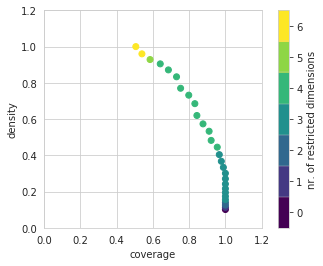

In [4]:
box1.show_tradeoff()
plt.show()

Since we are doing this analysis in a notebook, we can take advantage of the interactivity that the browser offers. A relatively recent addition to the python ecosystem is the library [altair](https://altair-viz.github.io/getting_started/overview.html). Altair can be used to create interactive plots for use in a browser. Altair is an optional dependency for the workbench. If available, we can create the following visual.

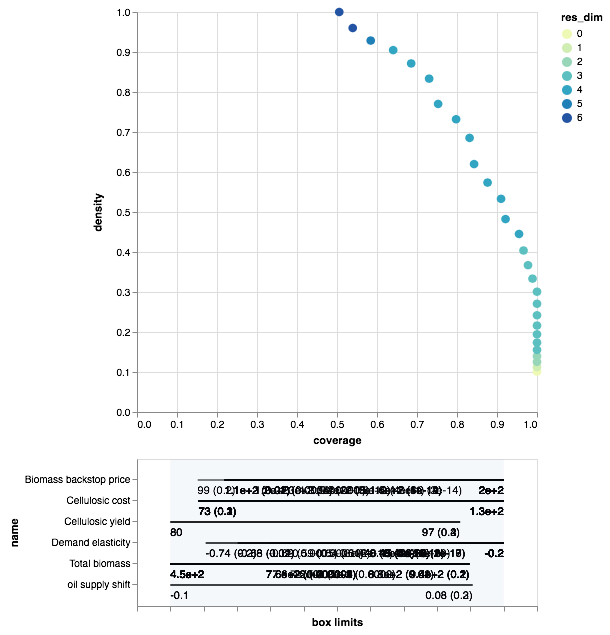

In [5]:
box1.inspect_tradeoff()

Here we can interactively explore the boxes associated with each point in the density coverage trade-off. It also offers mouse overs for the various points on the trade off curve. Given the id of each point, we can also use the workbench to manually inpect the peeling trajectory. Following Bryant & Lempert, we inspect box 21. 

In [6]:
box1.resample(21)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
Total biomass,100.0,100.0
Demand elasticity,100.0,100.0
Biomass backstop price,100.0,100.0
Cellulosic cost,90.0,90.0
Cellulosic yield,20.0,20.0
Electricity coproduction,20.0,20.0
Feedstock distribution,0.0,0.0
Oil elasticity,0.0,0.0
oil supply shift,0.0,0.0


coverage     0.752809
density      0.770115
id                 21
mass        0.0986395
mean         0.770115
res_dim             4
Name: 21, dtype: object

                            box 21                                            
                               min         max                       qp values
Total biomass           450.000000  755.799988   [-1.0, 4.716968553178765e-06]
Demand elasticity        -0.422000   -0.202000  [1.1849299115762218e-16, -1.0]
Biomass backstop price  150.049995  199.600006   [3.515112530263049e-11, -1.0]
Cellulosic cost          72.650002  133.699997     [0.15741333528927348, -1.0]



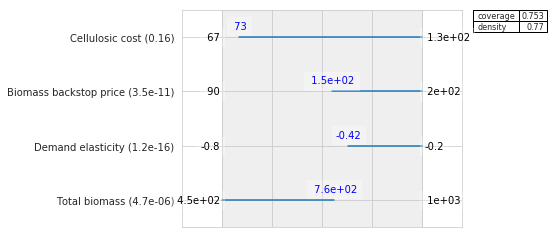

In [7]:
box1.inspect(21)
box1.inspect(21, style='graph')
plt.show()

If one where to do a detailed comparison with the results reported in the original article, one would see small numerical differences. These differences arise out of subtle differences in implementation. The most important difference is that the exploratory modeling workbench uses a custom objective function inside prim which is different from the one used in the scenario discovery toolkit. Other differences have to do with details about the hill climbing optimization that is used in prim, and in particular how ties are handled in selected the next step. The differences between the two implementations are only numerical, and don't affect the overarching conclusions drawn from the analysis. 

Let's select this 21 box, and get a more detailed view of what the box looks like. Following Bryant et al., we can use scatter plots for this. 

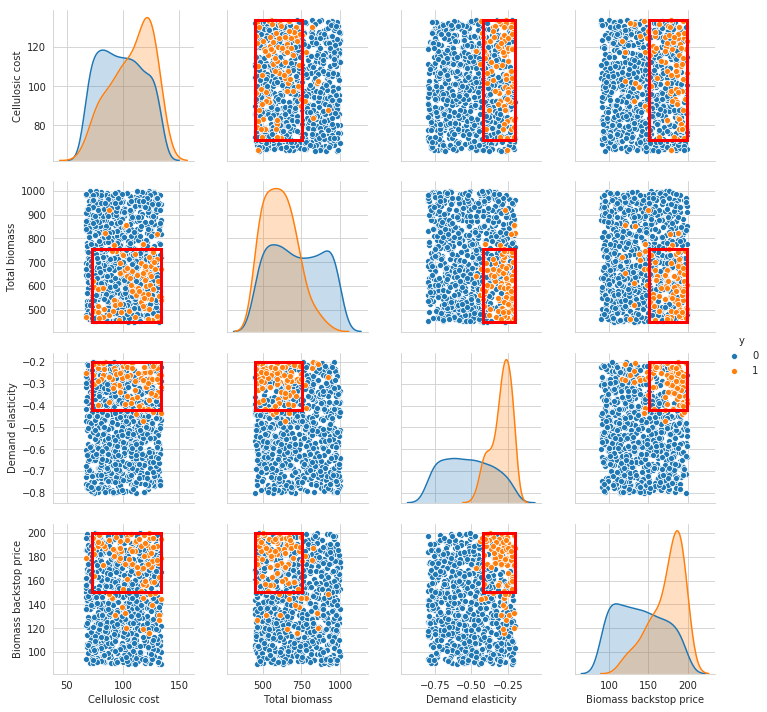

In [8]:
box1.select(21)
fig = box1.show_pairs_scatter(21)
plt.show()

Because the last restriction is not significant, we can choose to drop this restriction from the box. 

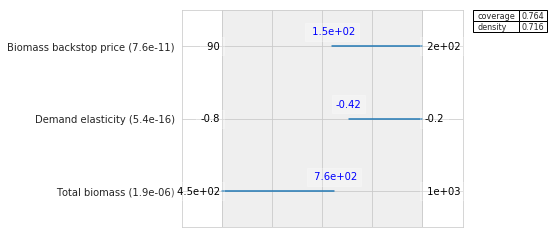

In [9]:
box1.drop_restriction('Cellulosic cost')
box1.inspect(style='graph')
plt.show()

We have now found a first box that explains over 75% of the cases of interest. Let's see if we can find a second box that explains the remainder of the cases.

In [10]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 787 points remaining, containing 21 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.3541666666666667, returning dump box


As we can see, we are unable to find a second box. The best coverage we can achieve is 0.35, which is well below the specified 0.8 threshold. Let's look at the final overal results from interactively fitting PRIM to the data. For this, we can use to convenience functions that transform the stats and boxes to pandas data frames.

In [11]:
prim_alg.stats_to_dataframe()

,coverage,density,mass,res_dim
box 1,0.764045,0.715789,0.10771,3
box 2,0.235955,0.026684,0.89229,0


In [12]:
prim_alg.boxes_to_dataframe()

box 1              box 2            
                               min         max    min         max
Demand elasticity        -0.422000   -0.202000   -0.8   -0.202000
Biomass backstop price  150.049995  199.600006   90.0  199.600006
Total biomass           450.000000  755.799988  450.0  997.799988

# CART

The way of interacting with CART is quite similar to how we setup the prim analysis. We import cart from the analysis package. We instantiate the algorithm, and next fit CART to the data. This is done via the `build_tree` method.

In [13]:
from ema_workbench.analysis import cart
cart_alg = cart.CART(x,y, 0.05)
cart_alg.build_tree()

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Now that we have trained CART on the data, we can investigate its results. Just like PRIM, we can use `stats_to_dataframe` and `boxes_to_dataframe` to get an overview. 

In [14]:
cart_alg.stats_to_dataframe()

,coverage,density,mass,res dim
box 1,0.011236,0.021739,0.052154,2
box 2,0.000000,0.000000,0.546485,2
box 3,0.000000,0.000000,0.103175,2
box 4,0.044944,0.090909,0.049887,2
box 5,0.224719,0.434783,0.052154,2
box 6,0.112360,0.227273,0.049887,3
box 7,0.000000,0.000000,0.051020,3
box 8,0.606742,0.642857,0.095238,2


In [15]:
cart_alg.boxes_to_dataframe()

box 1                  box 2               box 3  \
                         min         max        min         max     min   
Cellulosic yield        80.0   81.649998  81.649998   99.900002  80.000   
Demand elasticity       -0.8   -0.439000  -0.800000   -0.439000  -0.439   
Biomass backstop price  90.0  199.600006  90.000000  199.600006  90.000   

                                         box 4                box 5  \
                               max         min         max      min   
Cellulosic yield         99.900002   80.000000   99.900002   80.000   
Demand elasticity        -0.316500   -0.439000   -0.316500   -0.439   
Biomass backstop price  144.350006  144.350006  170.750000  170.750   

                                      box 6                  box 7  \
                               max      min         max        min   
Cellulosic yield         99.900002  80.0000   89.049999  89.049999   
Demand elasticity        -0.316500  -0.3165   -0.202000  -0.316500   
Biomass backstop price  199.600006  90.0000  148.300003  90.000000   

                                         box 8              
                               max         min         max  
Cellulosic yield         99.900002   80.000000   99.900002  
Demand elasticity        -0.202000   -0.316500   -0.202000  
Biomass backstop price  148.300003  148.300003  199.600006

Alternatively, we might want to look at the classification tree directly. For this, we can use the `show_tree` method. 

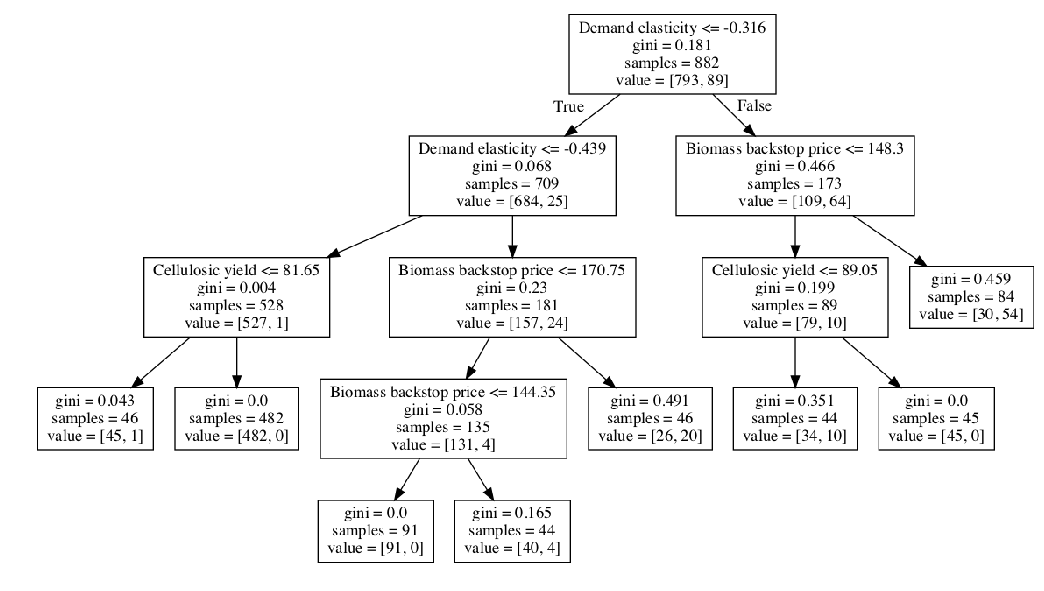

In [16]:
fig = cart_alg.show_tree()
fig.set_size_inches((18, 12))
plt.show()